请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

# AI达人创造营第二期--基于PaddleX的安全帽检测  
**作业四：撰写项目README并完成开源**

## 评分标准
1.格式规范（有至少3个小标题，内容完整），一个小标题5分，最高20分

2.图文并茂，一张图5分，最高20分

3.有可运行的代码，且代码内有详细注释，20分

4.代码开源到github，15分

5.代码同步到gitee，5分

## 作业目的
使用MarkDown撰写项目并且学会使用开源工具。



## 参考资料：
- [如何写好一篇高质量的精选项目？](https://aistudio.baidu.com/aistudio/projectdetail/2175889)

## 一、项目背景介绍
在施工现场，对于来往人员，以及工作人员而言，安全问题至关重要。而安全帽更是保障施工现场在场人员安全的第一防线，因此需要对场地中的人员进行安全提醒。当人员未佩戴安全帽进入施工场所时，人为监管耗时耗力，而且不易实时监管，过程繁琐、消耗人力且实时性较差。针对上述问题，希望通过视频监控->目标检测->智能督导的方式智能、高效的完成此任务:  

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/63b901ca44ca482abb31511b8b99faed4cdbad7d9d7c467e8cdd169181895bb4" width = "500"></center>
<center><br>图1：安全施工图 </br></center>
<br></br>



# 二、数据处理
**2.1PaddleX简介：**  
PaddleX是飞桨全流程开发工具，集飞桨核心框架、模型库、工具及组件等深度学习开发所需全部能力于一身，打通深度学习开发全流程，并**提供简明易懂的Python API**，方便用户根据实际生产需求进行直接调用或二次开发，为开发者提供飞桨全流程开发的最佳实践。目前，该工具代码已开源于GitHub，同时可访问PaddleX在线使用文档，快速查阅读使用教程和API文档说明。  
[PaddleX代码GitHub链接](https://github.com/PaddlePaddle/PaddleX/tree/develop)  
[PaddleX文档链接](https://paddlex.readthedocs.io/zh_CN/develop/index.html)  
**2.2安装PaddleX**  

In [1]:
!pip install paddlex -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 1.6 MB 8.4 MB/s            
     |████████████████████████████████| 310 kB 23.5 MB/s            
     |████████████████████████████████| 2.0 MB 24.6 MB/s            
     |████████████████████████████████| 151 kB 26.7 MB/s            
     |████████████████████████████████| 6.8 MB 15.0 MB/s            
     |████████████████████████████████| 106 kB 13.9 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 2.7 MB 31.6 MB/s            
     |████████████████████████████████| 1.5 MB 10.4 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 296 kB 20.9 MB/s            
     |████████████████████████████████| 50 kB 6.9 MB/s             
     |████████████████████████████████| 98 kB 15.4 MB/s            
     |█████

**2.3挂载数据集**




In [2]:
!unzip -oq data/data50329/HelmetDetection.zip -d data/ #把所挂载的数据集archive.zip解压到data/Helmet文件夹目录下

**2.4划分数据集**  

需要在data文件夹下 对解压出来的 annotatios文件夹重命名成---Annotations
images文件夹重命名成JPEGImages文件夹

In [3]:
!paddlex --split_dataset --format VOC --dataset_dir /home/aistudio/data/ --val_value 0.2 --test_value 0.1#划分数据集

[02-22 16:21:12 MainThread @logger.py:242] Argv: /opt/conda/envs/python35-paddle120-env/bin/paddlex --split_dataset --format VOC --dataset_dir /home/aistudio/data/ --val_value 0.2 --test_value 0.1
[02-22 16:21:12 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-p

# 三、模型选择和调参
**3.1 YOLOv3模型设计思想**

YOLOv3算法的基本思想可以分成两部分：

* 按一定规则在图片上产生一系列的候选区域，然后根据这些候选区域与图片上物体真实框之间的位置关系对候选区域进行标注。跟真实框足够接近的那些候选区域会被标注为正样本，同时将真实框的位置作为正样本的位置目标。偏离真实框较大的那些候选区域则会被标注为负样本，负样本不需要预测位置或者类别。
* 使用卷积神经网络提取图片特征并对候选区域的位置和类别进行预测。这样每个预测框就可以看成是一个样本，根据真实框相对它的位置和类别进行了标注而获得标签值，通过网络模型预测其位置和类别，将网络预测值和标签值进行比较，就可以建立起损失函数。

YOLOv3算法训练过程的流程图如 **图2** 所示：

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/f2eb2b75bb5a4e518b86a257e0f931de7377dba3bba44d1e846b307036aed41a" width = "800"></center>
<center><br>图2：YOLOv3算法训练流程图 </br></center>
<br></br>


* **图2** 左边是输入图片，上半部分所示的过程是使用卷积神经网络对图片提取特征，随着网络不断向前传播，特征图的尺寸越来越小，每个像素点会代表更加抽象的特征模式，直到输出特征图，其尺寸减小为原图的$\frac{1}{32}$。
* **图2** 下半部分描述了生成候选区域的过程，首先将原图划分成多个小方块，每个小方块的大小是$32 \times 32$，然后以每个小方块为中心分别生成一系列锚框，整张图片都会被锚框覆盖到。在每个锚框的基础上产生一个与之对应的预测框，根据锚框和预测框与图片上物体真实框之间的位置关系，对这些预测框进行标注。
* 将上方支路中输出的特征图与下方支路中产生的预测框标签建立关联，创建损失函数，开启端到端的训练过程。

这里我们直接用PaddleX调用YOLOv3模型

**3.2配置GPU**

In [4]:
import matplotlib
matplotlib.use('Agg') 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import paddlex as pdx

[02-22 16:26:31 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()


**3.3 定义图像处理流程transforms**     
定义数据处理流程，其中训练集和验证集需分别定义，训练过程包括了部分测试过程中不需要的数据增强操作，如在本示例中，训练过程使用了MixupImage、RandomDistort、RandomExpand、RandomCrop和RandomHorizontalFlip共5种数据增强方式，更多图像预处理流程transforms的使用可参见paddlex.det.transforms。

In [5]:
import paddlex as pdx
from paddlex import transforms as T
train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=250), T.RandomDistort(),
    T.RandomExpand(im_padding_value=[123.675, 116.28, 103.53]), T.RandomCrop(),
    T.RandomHorizontalFlip(), T.BatchRandomResize(
        target_sizes=[320, 352, 384, 416, 448, 480, 512, 544, 576, 608],
        interp='RANDOM'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = T.Compose([
    T.Resize(
        608, interp='CUBIC'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

**3.4 定义数据集Dataset**  
目标检测可使用VOCDetection格式和COCODetection两种数据集，此处由于数据集为VOC格式，因此采用pdx.datasets.VOCDetection来加载数据集，该接口的介绍可参见文档paddlex.datasets.VOCDetection。

In [6]:
train_dataset = pdx.datasets.VOCDetection(
    data_dir='data',
    file_list='data/train_list.txt',
    label_list='data/labels.txt',
    transforms=train_transforms,
    shuffle=True)

eval_dataset = pdx.datasets.VOCDetection(
    data_dir='data',
    file_list='data/val_list.txt',
    label_list='data/labels.txt',
    transforms=eval_transforms,
    shuffle=False)

2022-02-22 16:26:43 [INFO]	Starting to read file list from dataset...
2022-02-22 16:26:52 [INFO]	3500 samples in file data/train_list.txt, including 3500 positive samples and 0 negative samples.
creating index...
index created!
2022-02-22 16:26:52 [INFO]	Starting to read file list from dataset...
2022-02-22 16:26:55 [INFO]	1000 samples in file data/val_list.txt, including 1000 positive samples and 0 negative samples.
creating index...
index created!


**2.4 模型选择**  
使用YOLOv3模型，DarkNet53网络

In [7]:
num_classes = len(train_dataset.labels)
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='DarkNet53')

W0222 16:27:00.423406   150 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0222 16:27:00.429230   150 device_context.cc:465] device: 0, cuDNN Version: 7.6.


# 四、模型训练
**4.1配置超参数训练模型**

In [8]:
model.train(
    num_epochs=30,
    train_dataset=train_dataset,
    train_batch_size=20,
    eval_dataset=eval_dataset,
    learning_rate=0.001 / 8,
    warmup_steps=1000,
    warmup_start_lr=0.0,
    save_interval_epochs=5,
    lr_decay_epochs=[216, 243],
    save_dir='output/yolov3_darknet53')

2022-02-22 16:27:05 [INFO]	Downloading DarkNet53_pretrained.pdparams from https://paddledet.bj.bcebos.com/models/pretrained/DarkNet53_pretrained.pdparams


100%|██████████| 158704/158704 [00:06<00:00, 23558.69KB/s]


2022-02-22 16:27:12 [INFO]	Loading pretrained model from output/yolov3_darknet53/pretrain/DarkNet53_pretrained.pdparams
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv0.conv.weight is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv0.batch_norm.weight is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv0.batch_norm.bias is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv0.batch_norm._mean is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv0.batch_norm._variance is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv1.conv.weight is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv1.batch_norm.weight is not in pretrained model
2022-02-22 16:27:12 [WARNING]	neck.yolo_block.0.conv_module.conv1.batch_norm.bias is not in pretrained model
2022-0

<center>step次数 如 **图3** 所示：
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d9f51b579bd24bfbb517fba3d9492bfedf88bb90609d4068a4ba82ffb9a10bb9" width="70%" height="60%"></center>
<center><br>图3：step次数 </br></center>
<br></br>



**Train samples: 3500, num_epochs=50(这里算1轮的50没乘), train_batch_size=20, Step=175**




In [12]:
import paddlex as pdx
model = pdx.load_model('output/yolov3_darknet53/best_model')
image_name = 'data/JPEGImages/hard_hat_workers10.png'

result = model.predict(image_name)
print(result)
pdx.det.visualize(image_name, result, threshold=0.5, save_dir='./output/yolov3_darknet53')

2022-02-20 11:45:50 [INFO]	Model[YOLOv3] loaded.
[{'category_id': 1, 'category': 'helmet', 'bbox': [219.2314910888672, 67.85906219482422, 40.06431579589844, 46.71452331542969], 'score': 0.9880556464195251}, {'category_id': 1, 'category': 'helmet', 'bbox': [370.7378845214844, 132.32089233398438, 33.49871826171875, 36.958831787109375], 'score': 0.9075238108634949}, {'category_id': 1, 'category': 'helmet', 'bbox': [287.16180419921875, 132.24415588378906, 36.34478759765625, 38.101318359375], 'score': 0.5806847810745239}, {'category_id': 1, 'category': 'helmet', 'bbox': [190.13345336914062, 95.6458511352539, 42.21429443359375, 35.475914001464844], 'score': 0.05387658253312111}, {'category_id': 2, 'category': 'person', 'bbox': [271.3753662109375, 146.70663452148438, 54.404052734375, 118.34365844726562], 'score': 0.01536149624735117}, {'category_id': 2, 'category': 'person', 'bbox': [163.5753936767578, 90.10127258300781, 96.08778381347656, 145.990234375], 'score': 0.01054970920085907}]
2022-0

**Notebook版本选BML Codecolab 选择output-yolov3_darknet53-vdl_log--里面的XXXX.log文件 启动VisualDL**
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/ff79ecab80724f2f8ab1076babb21efcadb1e8ceb6614639a86261c601c61df7" width="70%" height="60%"></center>
<center><br>图4：调用可视化方法 </br></center>

**训练验证图示如下**
<center>iteration次数 如 **图3** 所示：
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/26b6bd8cc25b41d0a1d734a75cb24fc74cd88621794f46e986cbbeee128ec618" width="90%" height="90%"></center>
<center><br>图5：训练验证图 </br></center>
<br></br>



# 五、可视化模型效果

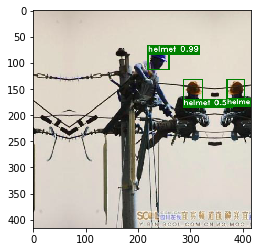

In [13]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(cv2.imread("output/yolov3_darknet53/visualize_hard_hat_workers10.png"))